# Определение возраста покупателей

**Описание проекта**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
•	анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
•	контролировать добросовестность кассиров при продаже алкоголя.
Нам необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием их возраста.


**Описание данных**

У нас есть данные с сайта ChaLearn Looking at People. Они уже загружены в папку /datasets/faces/. У нас есть папка со всеми изображениями (/final_files) и CSV-файл labels.csv с двумя колонками: file_name и real_age. В CSV-файле по сути для каждой фотографии (по названию фотографии) указана метка - наш целевой признак со значением возраста.


## Исследовательский анализ данных

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

In [2]:
# загружаем данные c названием фото и возрастом в датафрейм
path_1 = 'https://code.s3.yandex.net//datasets/faces/labels.csv'
path_2 = '/datasets/faces/labels.csv'
if os.path.exists(path_1):
    labels = pd.read_csv(path_1)
elif os.path.exists(path_2):
    labels = pd.read_csv(path_2)
else:
    print('Something is wrong')

In [3]:
# выводим общую информацию по датафрейму с метками
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
# выводим первые строки датафрейма
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
# выгружаем фотографии покупателей
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
datagen_flow = datagen.flow_from_dataframe(dataframe=labels,
                                          directory='/datasets/faces/final_files/',
                                          x_col='file_name',
                                          y_col='real_age',
                                          target_size=(224, 224),
                                          batch_size=32,
                                          class_mode='raw',
                                          seed=12345)

Found 7591 validated image filenames.


In [6]:
# выводим описательную статистику для целевого признака
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

In [7]:
# 10 наиболее популярных значений возраста
labels['real_age'].value_counts().head(10)

30    317
25    315
27    229
26    226
28    217
23    213
24    211
18    193
16    193
19    180
Name: real_age, dtype: int64

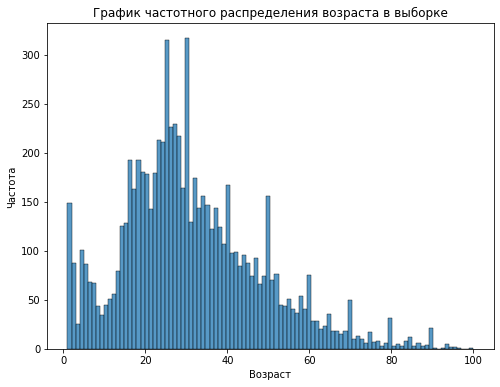

In [8]:
# строим гистограмму распределения возраста
plt.figure(figsize=(8,6))
sns.histplot(data=labels, x='real_age', bins=100)
plt.title("График частотного распределения возраста в выборке")
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.show()

In [9]:
# формируем пары «картинки — метки»
features, target = next(datagen_flow)
# размерность полученных входных пhизнаков - картинок
features.shape

(32, 224, 224, 3)

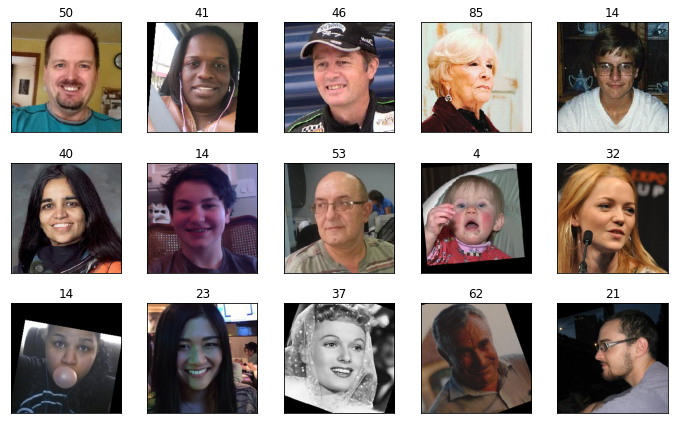

In [10]:
# выводим 15 изображений датасета
fig = plt.figure(figsize=(10,6))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.title(target[i])
    plt.tight_layout()

**Выводы:**

Мы выгрузили входные данные и целевой признак, а затем посмотрели на них. Распределение целевого признака на шкале от 0 до 100 (минимальное и максимальное значение) показывает смещение возраста влево, где медианное значение приходится на 29 лет, среднеарифмитечиское на 31 год, а наиболее популярное (модальное) значение возраста на 30 лет. Интервал в 25-30 лет является наиболее популярным по всей выборке. В то же время мы видим, что в выборке сравнительно большую долю занимают дети и подростки в возрасте от 0 до 15 лет. Также довольно популярна группа от 15 до 20 лет, по которой проходит пороговое значение для продажи алкоголя, поэтому важно точно распознавать возраст в этом интервале. На возрастные группы старше 60 лет приходится сравнительно немного фотографий в датасете. Мы видим, что в среднем на каждое значение возраста приходится порядка 76 фотографий, а в тренировочной выборке ещё меньше, т.е. сравнительно немного. На шаге исследовательского анализа данных можно сделать вывод, что для того, чтобы избежать переобучения модели на тренировочной выборке, будет полезно использовать аугментацию входных данных.

Мы также вывели на экран 15 фотографий и убедились, что в датасете у нас довольно объемные изображения с 3-х цветной глубиной. Однозначно, при выборе модели для обучения и прогнозирования целевого признака нам следует отказаться от полносвязных нейронных сетей в пользу сверточных нейронных сетей, чтобы модель лучше и быстрее обучилась на сложных изображениях. Для повышения точности прогнозной модели также имеет смысл обратиться к предобученной сверточной нейросети ResNet.

## Обучение модели

```python
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd

def load_train(path):
    df = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25,
                                 rescale=1./255,
                                 horizontal_flip=True,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2)   
    train_datagen_flow = datagen.flow_from_dataframe(dataframe = df,
                                                     directory = path + 'final_files/',
                                                     x_col = 'file_name',
                                                     y_col = 'real_age',
                                                     target_size=(224, 224),
                                                     batch_size=32,
                                                     class_mode='raw',
                                                     subset='training',
                                                     seed=12345)
    return train_datagen_flow

def load_test(path):
    df = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25,
                                 rescale=1./255) 
    test_datagen_flow = datagen.flow_from_dataframe(dataframe = df,
                                                    directory = path + 'final_files/',
                                                    x_col = 'file_name',
                                                    y_col = 'real_age',
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='raw',
                                                    subset='validation',
                                                    seed=12345)
    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)
    backbone.trainable = True
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer= Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10, 
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 128s - loss: 241.1697 - mae: 11.1845 - val_loss: 888.8385 - val_mae: 24.9610
Epoch 2/10
178/178 - 115s - loss: 93.5650 - mae: 7.2762 - val_loss: 854.1815 - val_mae: 24.3465
Epoch 3/10
178/178 - 115s - loss: 70.1561 - mae: 6.3630 - val_loss: 379.2813 - val_mae: 14.7288
Epoch 4/10
178/178 - 117s - loss: 58.1095 - mae: 5.8417 - val_loss: 127.3242 - val_mae: 8.3403
Epoch 5/10
178/178 - 116s - loss: 46.9661 - mae: 5.2646 - val_loss: 131.7953 - val_mae: 8.9219
Epoch 6/10
178/178 - 118s - loss: 41.2005 - mae: 4.9227 - val_loss: 69.4398 - val_mae: 6.1744
Epoch 7/10
178/178 - 117s - loss: 35.5815 - mae: 4.5613 - val_loss: 127.3954 - val_mae: 8.5293
Epoch 8/10
178/178 - 118s - loss: 32.2153 - mae: 4.3472 - val_loss: 63.8314 - val_mae: 5.9154
Epoch 9/10
178/178 - 117s - loss: 28.6021 - mae: 4.0873 - val_loss: 76.5597 - val_mae: 6.6490
Epoch 10/10
178/178 - 118s - loss: 27.2386 - mae: 4.0075 - val_loss: 66.9566 - val_mae: 6.1011

```

## Анализ обученной модели

На этапе исследовательского анализа данных мы познакомились с данными и проанализировали целевой и входные признаки. После выгрузки целевого признака (возраста) мы вывели описательную статистику и потсроили гистограмму распределения по признаку. Распределение целевого признака на шкале от 0 до 100 показывает смещение возраста влево — медианное значение приходится на 29 лет, среднеарифмитечиское на 31 год, а модальное на 30 лет. Интервал в 25-30 лет является наиболее популярным по всей выборке. График показывает, что в выборке сравнительно большую долю занимают дети и подростки в возрасте от 0 до 15 лет. Также довольно популярна группа от 15 до 20 лет, по которой проходит пороговое значение для продажи алкоголя, поэтому важно относительно точно распознавать возраст для этого и соседних интервалов. Сравнительно немного фотографий в датасете приходится на возрастные группы старше 60 лет. Можно заметить, что на каждое значение возраста в тренировочной выборки датасета приходится сравнительно немного фотографий — менее 60. Мы также сделали вывод по результатам исследовательского анализа, что для того, чтобы избежать переобучения модели на тренировочной выборке, будет полезно использовать аугментацию входных данных. Мы вывели несколько изображений из датасета и убедились, что у нас заданы довольно объемные изображения с 3-х цветной глубиной. Однозначно, при выборе модели для обучения и прогнозирования целевого признака мы решили отказаться от полносвязных нейронных сетей в пользу сверточных нейронных сетей, чтобы модель лучше и быстрее обучилась на сложных изображениях. Для повышения точности прогнозной модели мы также решили обратиться к предобученной сверточной неронной сети ResNet50.

После исследовательского анализа данных мы написали 4 функции для загрузки: тренировочных и тествовых данных, создания модели и обучения модели для определения возраста по фотографии. Для загрузки данных мы использовали загрузчик данных ImageDataGenerator. Мы создали разные генераторы для тренировочной и тестовой выборок: для тренировочной выборки мы настроили параметры аугментации. Мы задали параметр validation_split=0.25 в ImageDataGenerator, а затем при применении метода flow_from_dataframe установили соответствующие значения параметра subset для каждой выборки. Так на основе одних и тех же данных мы получили 2 разные выборки. Мы масштабировали векторные значения входного признака для обоих выборок по шкале от 0 до 1. Мы определили размер батча равным 32. В функции для создания модели мы применили предобученную нейросеть ResNet50 без верхушки и сконструировали её заново. Заморозку нейросети мы не использовали, т.к. у нас сравнительно большой датасет. Мы также применили пулинг с окном во весь тензор — GlobalAveragePooling2D. И последний слой в нашей модели - Dense c одним нейроном и параметром активации ReLU, который приводит к 0 все значения меньше 0. В качестве алгоритма обучения нейронной сети мы выбрали Adam, которрый показывает лучшие результаты по сравнению с градиентным спуском (sgd). Мы выбрали значение гиперпараметра скорости обучения learning_rate=0.001. В качестве функции потерь мы выбрали MSE (среднее квадратичное отклонение), а в качестве метрики качества модели MAE (средняя абсолютная ошибка).

Для обучения мы использовали 10 эпох, решив что меньше может быть недостаточно, а больше займет больше времени. В результате после 10 эпох обучения модель достигла достаточно хорошего показателя качества (MAE). Заметно, что в первых двух эпохах модель показывала гораздо худшее качество на тествой выборке по сравнению с тренировочной, в споследующие эпохи мы видим, что показатели качества в значительной степени выровнялись, т.е. нет заметной разницы в результатах модели на тренировочной и тестовой выборках, значит нам удалось избежать переобучения модели на тренировочной выборке. На 10-й эпохе значение метрики качества MAE=6.1, что можно считать очень хорошим результатом. Обучение каждой эпохи занимает около 2 минут, а в целом наша модель обучилась в пределах 20 минут.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы